## A brief introduction to Gaussian Processes

A stochastic process is an indexed collection of random variables. For a Gaussian Process (GP), any its finite realization has a multivariate normal distribution. And this is the definition of a GP.

GPs allow to specify priors over the space of continuous functions and hence belong to the non-parametric group of models. Each sample from a GP is an entire function, indexed by a set of coordinates belonging to some set $X$ (we will deal here only with $X \in \mathbb{R}^D$), which it maps into a real-valued output.

A GP prior on the function 𝑓(𝑥) is usually written as

$$ f(x) \sim GP(m(x), k(x,x')).$$

Here $m(x)$ denotes the mean function, and $k(x, x')$ denotes the covariance function. The mean function describes the baseline of the process. Its value at point $x$ is an average of an infinite number of realisations of the GP evaluated at point $x$. The covariance function or covariance kernel, controls variance-covariance structure: its value at a set of two points $k(x, x')$ quantifies the covariance of two random variables $f(x)$ and $f(x')$. Similarly to a finite multivariate normal distribution, a GP is completely specified by its mean and covariance.

For finite-dimensional realizations of a multivariate normal, the covariance $K=[k(x_i, x_j)], i, j =1,..,N$ is a square, symmetric positive-definite matrix. For a GP, the kernel should be positive-definite, meaning that its evaluation at any finite number of locations should results in a positive-definite matrix.

There are some connections between GPs from the point of view of their kernels, spectral representations, and stochastic differential equations (SDEs), but these topics are noot in scope of the current tutorial.

More infornation on GPs in general can be found in ["Gaussian Processes for Machine Learning", Rasmussen, Williams](http://www.gaussianprocess.org/gpml/) and ["Introduction to Gaussian processes", MacKay](https://www.ics.uci.edu/~welling/teaching/KernelsICS273B/gpB.pdf).


## Kernels

Kernel design is crucial for GP modelling since it describes the class of possible functions which can be captured: both the global shape, as well as local properties, such as smoothness.

Most commonly used kernels, are stationary, i.e. the covaricance function depends only on the distance between the coordinates, but not the coordiantes themselves: $k(x,x')=k(d)$, $d = \| x_1 - x_2 \|$. Examples of such kernels include exponential 

$$k(d)= \alpha^2\exp \left( -\frac{d}{\rho} \right),$$ 
squared exponential (a.k.a. "gaussian", "RBF") $$k(d)=\alpha^2\exp \left( -\frac{d^2}{2\rho^2} \right),$$ 
or Matern $$k(d)=C_{\nu, \rho}(d)$$ kernels. 

Curves, modelled by the squared exponential kernel would have smooth shapes, while Matern kernels under certain values of $\nu$ result in curves with more local fluctuations and less smoothness. The length-scale  $\rho$, common for many kernels, governs the flexibility of the curves: smaller length-scales induce correlations between points at smaller distances and hence more oscillatory behaviour - such behaviour, when exaggerated, can lead to overfitting; too large length-scales, on the other hand, make curve fits too inflexible and may lead to underfitting the data. The amplitude $\alpha$, frequently applied to kernels as a constant multiplier, controls the expected variation in the output. The amplitude controls how strong the functions fluctuate and the length-scale controls how rapidly they fluctuate. 

Choice of priors of the GP parameters plays a big role in their identifiability. 

Covariance functions can be scaled, multiplied, summed with each other and further modified to achieve a desired effect. For instance, if it is known that a curve behaves differently in different areas of its input values, changepoint kernel would provide a reasonable model. The desired global GP can be then constructed as a weighted average of two or more local GPs, i.e. if the two local GPs are 

$$f_1(x) \sim \text{GP}(0,k_1)$$ and 
$$f_2(x) \sim \text{GP}(0,k_2),$$
we can define a global GP as 
$$f(x) := (1 - w(x)) f_1(x) + w(x) f_2(x) \sim \text{GP}(0,k).$$ 

Here $w(x)$ is a weighting function, ensuring continuous transition from $f_1$ to $f_2$. The resulting kernel $k$ can be computed as 

$$k(x, x^{'}) = (1 - w(x)) k_1(x, x') (1 - w(x')) + w(x) k_2(x, x')\sigma(x').$$

Standard choice of the weighting function is the sigmoidal $w(x)=\sigma(x),$ providing a transition from $f_1$ to $f_2,$ with the changepoint located at zero. 

An overview of these and other kernels can be found in [the kernel cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/).

## Prediction and complexity

The prediction task can be formulated as follows: given a set of observed input-output  pairs $(x^\text{obs}_i, y^\text{obs}_i), i=1,..N$, compute the output values $y^\text{pred}_i, i=1,...,M$ at locations $x^\text{pred}_i, i=1,...,M.$ Jointly, observed and unobserved values are distributed as a multivariate normal


$$\begin{bmatrix} f^\text{obs}_N \\ f^\text{pred}_M \end{bmatrix} 
\sim 
\text{MVN} \left( \begin{bmatrix} \mu^\text{obs}_N \\ \mu^\text{pred}_M \end{bmatrix}, \begin{bmatrix} K^\text{obs}_{NN} & K^\text{obs, pred}_{NM} \\ (K^\text{obs, pred}_{NM})^T & K^\text{pred}_{MM} \end{bmatrix} \right).
$$

Due to the properties of the multivariate normal distribution, the distribution of the unobserved values given the observed values is given by 

$$f^\text{pred}_M \mid f^\text{obs}_N \sim \text{MVN}(\underline{m}, \Sigma),$$

where

$$\underline{m} = \mu^\text{pred}_M + \left(K^\text{obs, pred}_{NM} \right)^T *  \left(K^\text{obs}_{NN} \right)^{-1}*(f^\text{obs}_N - \mu^\text{obs}_N)$$ 

$$\Sigma = K^\text{pred}_{MM} - \left(K^\text{obs, pred}_{NM} \right)^T *  \left(K^\text{obs}_{NN} \right)^{-1}*K^\text{obs, pred}_{NM}.$$

Both expressions for $\underline{m}$ and $\Sigma$ involve the product of two matrices, hence it could be useful to precompute it: 

$$\tilde{K} = \left(K^\text{obs, pred}_{NM} \right)^T *  \left(K^\text{obs}_{NN} \right)^{-1} = \left(K^\text{pred, obs}_{MN} \right) *  \left(K^\text{obs}_{NN} \right)^{-1},$$

and then 

$$\underline{m} = \mu^\text{pred}_M + \tilde{K}*(f^\text{obs}_N - \mu^\text{obs}_N)$$ 

$$\Sigma = K^\text{pred}_{MM} - \tilde{K}*K^\text{obs, pred}_{NM}.$$

From the above expressions it follows, that the most computationally costly operation is $\left(K^\text{obs}_{NN} \right)^{-1}$ which has complexity $O(N^3).$ This makes the application of vanilla GPs to large data sets prohibitive. A series of methods has been developed to overcome this issue, but we will not cover them here.

## Modelling workflow

Typically, the workflow of any predictive task consists of three major steps:

- data preparation,
- inference,
- prediction.

At the inference step, model parameters are being estimated, and at the predictoin step these estimates are used to compute the value of the function at unobserved locations.

In the Bayesian framework, we additionally perform

- prior predictive checks,
- convergence diagnostics,
- posterior predictive checks.

These steps alltogether, combined and iterated, comprise the [Bayesian workflow](https://arxiv.org/abs/2011.01808).

## What is in this tutorial

This tutorial demonstrates how to use Julia's infrastructure, including such packages as **Turing.jl**, **KernelFunctions.jl** and **AbastractGPs.jl**, to fit models with Gaussian Processes.

### Bibliography

1. "Gaussian Processes for Machine Learning", Rasmussen, Williams

2. "Introduction to Gaussian processes", David MacKay

3. "The Kernel Cookbook: Advice on Covariance functions", David Duvenaud

4. "Interpolation of Spatial Data: Some Theory for Kriging", Stein


## Hands-on example: a model with RBF kernel using KernelFunctions.jl and AbstractGPs.jl libraries

In [1]:
using Distributions
using StatsPlots 
using LinearAlgebra
using Turing
using Distances
using KernelFunctions
using AbstractGPs
using Random

### Simulate data

We simulate data $(x^\text{obs}_i, y^\text{obs}_i), i=1,..N$ as noisy evaluations of a known non-linear function $f(x)$ on a set of locations and define a *predictive grid*, i.e. a set of locations $x^{\text{pred},i}, i =1,...,M$ where we want to predict the values of $f.$ 

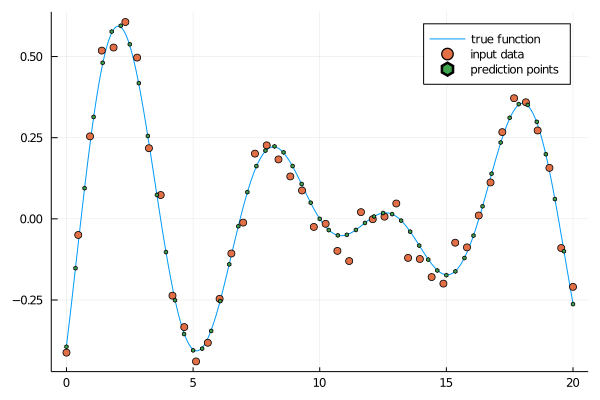

In [2]:
function sim_data(x, tau=0)
    y = (12 .- x) .* sin.(10 .- x)
    y = y ./ (maximum(y) - minimum(y)) + rand(Normal(0, tau^2), length(y)) 
end

# plot the true function
X_full = collect(range(0, stop = 20, length = 1000))
y_full = sim_data(X_full, 0)
p = plot(X_full, y_full, label="true function")

# simulate N input data points
N = 44
X = collect(range(0, stop = 20, length = N))
y = sim_data(X, 0.2)
scatter!(X, y, label="input data")

# predictive grid of M locations
M = 57
X_pred= collect(range(minimum(X_full), maximum(X_full), length = M))
scatter!(X_pred, sim_data(X_pred,0), markershape = :hexagon, markersize = 2, label="prediction points")

### Formulate the model

In [3]:
# defining the kernel
sqexpkernel(alpha::Real, rho::Real) = alpha^2 * transform(SqExponentialKernel(), 1/(rho*sqrt(2)))

sqexpkernel (generic function with 1 method)

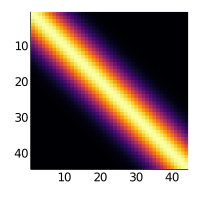

In [4]:
# visualisaing realizations of the kernel for given set of parameters
alpha =rand(LogNormal(0.0, 0.1))
rho = rand(LogNormal(1.0, 1.0))
kernel = sqexpkernel(alpha, rho)
K = kernelmatrix(kernel,X)
heatmap(K, yflip=true, colorbar=false, size=[200,200])

In [5]:
# Turing model
@model model(y, X) = begin

    # Priors.
    alpha ~ LogNormal(0.0, 0.1)
    rho ~ LogNormal(1.0, 1.0)
    tau ~ LogNormal(0.0, 1.0)

    kernel = sqexpkernel(alpha, rho)

    f = GP(kernel)
    
    # likelihood
    y ~ f(X, sqrt(tau^2 + 1e-6))
    
end;

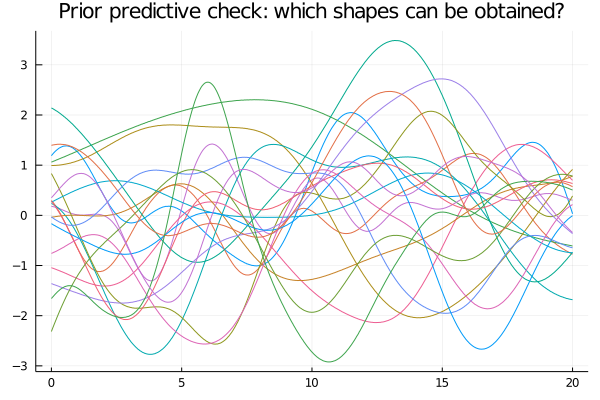

In [6]:
#let us draw 20 possible trajectories using the priors which we chose for the model

for i in 1:20
    
    alpha = rand(LogNormal(0.0, 0.1))
    rho = rand(InverseGamma(10, 20))
    
    kernel = sqexpkernel(alpha, rho)

    K = kernelmatrix(kernel,X_full) + 1e-6 * I(1000)
   
    mu =0 
    y_draw = rand(MvNormal(mu * ones(1000), K))

    if (i == 1)
        p = plot(X_full, y_draw, legend = false, title="Prior predictive check: which shapes can be obtained?")
    else 
        plot!(X_full, y_draw)
    end
end

display(p)

### Fit the model and diagnose convergence

In [8]:
m = model(y, X)
@time chain = sample(m, NUTS(500, 0.8), 1000)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/kcft114/.julia/packages/Turing/RzDvB/src/inference/hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


  6.107544 seconds (8.11 M allocations: 2.629 GiB, 10.65% gc time)


Chains MCMC chain (500×15×1 Array{Float64,3}):

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
parameters        = alpha, rho, tau
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat  
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64  
                                                                            
       alpha    0.9770    0.0926     0.0041    0.0038   448.6731    1.0011  
         rho    2.4309    0.2036     0.0091    0.0116   340.0826    0.9981  
         tau    0.0029    0.0011     0.0000    0.0000   372.5008    0.9980  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float

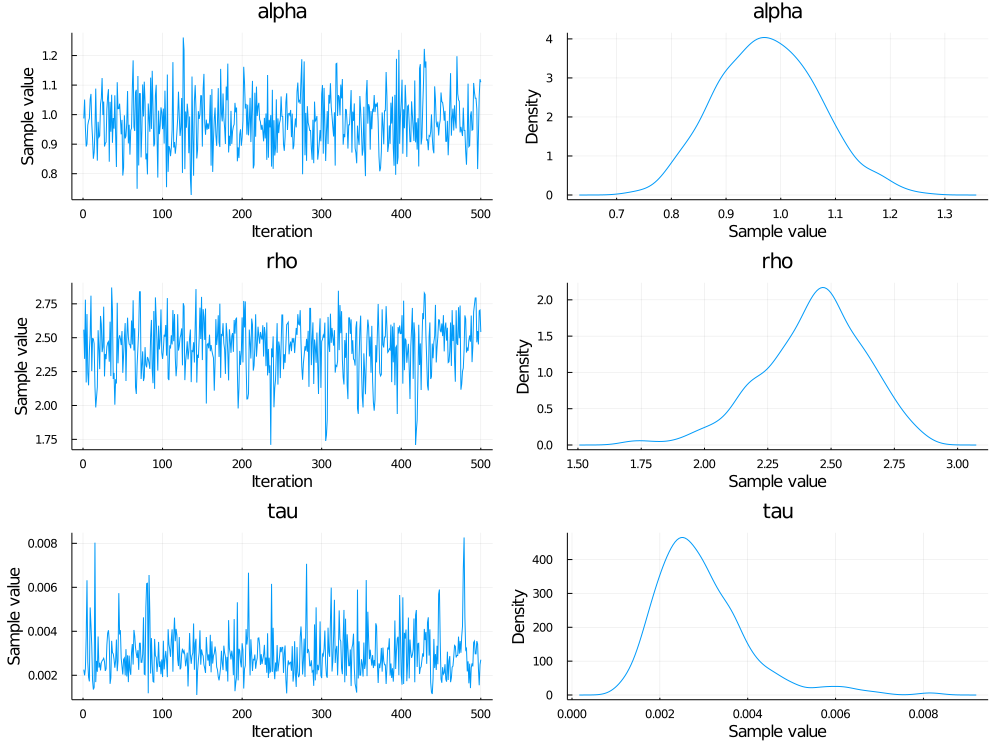

In [9]:
plot(chain)

### Prediction (kriging)

In [10]:
# extract posterior samples of model parameters
alpha_samps = chain[:alpha].data
rho_samps = chain[:rho].data;
tau_samps = chain[:tau].data;

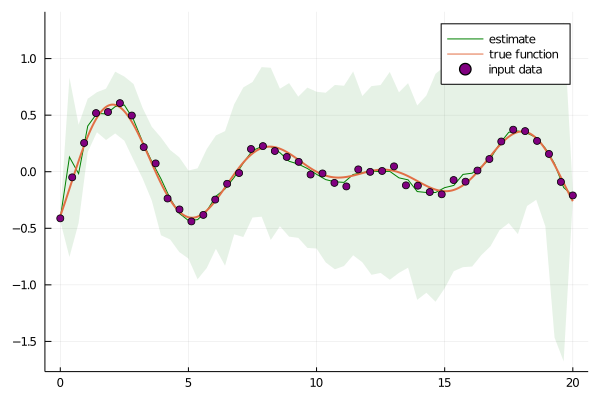

In [11]:
# fuction calculating preditcions
function gp_pred(X, X_pred, _alpha, _rho, _tau)

    kernel = sqexpkernel(_alpha, _rho)

    K_NN = kernelmatrix(kernel,X)
    K_MN = kernelmatrix(kernel, X_pred, X)
    K_MM = kernelmatrix(kernel, X_pred, X_pred)
    
    K_ = K_MN / K_NN  # important to write this instead of  K_NN_inv = inv(K_NN); K_ = K_MN * K_NN_inv
    
    _mu = 0
    m_ = _mu .+ K_ * (y .- _mu)
    
    Sigma = K_MM - K_ * K_MN' + (_tau^2 + 1e-6) *I
    Sigma = Symmetric(Sigma)
    y_pred = rand(MvNormal(m_, Sigma))
end

Nsamps = length(alpha_samps)
y_pred = [gp_pred(X, X_pred, alpha_samps[i], rho_samps[i], tau_samps[i]) for i in 1:Nsamps]
y_pred = hcat(y_pred...);

# visualizing predictions
y_quantiles = [quantile(y_pred[i, 1:Nsamps], [0.1, 0.5, 0.9]) for i in 1:M]
y_quantiles = hcat(y_quantiles...)

y_pred_lower = y_quantiles[1, 1:M]
y_pred_mean = y_quantiles[2, 1:M]
y_pred_upper = y_quantiles[3, 1:M];

# plot prediction with uncertainty
plot(X_pred, y_pred_mean, 
     ribbon=(y_pred_mean - y_pred_lower, y_pred_upper - y_pred_mean), fillalpha=0.1, c=:green,
     lab="estimate")

plot!(X_full, y_full, lab="true function", linewidth = 2)


# plot input data points
scatter!(X, y, lab="input data", c=:purple)